<figure>
  <IMG SRC="Logo.png"  WIDTH=150 ALIGN="right">
</figure>

## Projections of mean sea level and tides<br>
### Paper Journal of Hydraulic and Coastal Structures
<b>Prepared by: H.G. Voortman</b>


<figure>
    <IMG SRC="https://www.python.org/static/community_logos/python-powered-w-200x80.png"  WIDTH=100 ALIGN="right">
</figure>

#### Description
- Analyses section 5; tidal amplitudes

#### Packages

In [17]:
# General packages
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sq
import numpy as np
import sigfig as sf
#import scipy.signal as signal
#import datetime as dt
import hvec_stat.general_fit as gf
import hvec_stat.plotting as stplot
import hvec_stat.goodness_of_fit as gof
import hvec_stat.support as sup
from hvec_sealevel_scenarios import regressionModels as mdl
import utils as prj

In [18]:
# Settings
plt.rcParams['axes.grid'] = True
figsize = (20, 18)

In [19]:
tiny = 1e-12

In [20]:

var = 'M2+S2'

#### Connect databases and import data

##### Processed data Rijkswaterstaat

In [21]:
df = prj.read_data_rws(constit_set = 'Ftested3')
df = df.loc[df['year'] >= 1980]

#### F-test model 3

In [22]:
res = df.groupby('naam').apply(
    lambda x: pd.DataFrame(sup.Ftest_classic_direct(mdl.reducedModel, x['year'], x[var]), index = [0])
)
res.reset_index(inplace = True)
res.drop(columns = 'level_1', inplace = True)
res

,naam,F,p,alpha,Falpha,Reject H0?
0,Delfzijl,2.078401,0.080961,0.05,2.371781,False
1,Den Helder,5.135175,0.000710,0.05,2.371781,True
2,Harlingen,1.570829,0.184862,0.05,2.371781,False
3,Hoek van Holland,0.776755,0.593627,0.05,2.371781,False
4,IJmuiden,7.324657,0.000040,0.05,2.371781,True
5,Vlissingen,10.108899,0.000002,0.05,2.371781,True


In [23]:
names = res.loc[res['Reject H0?'], 'naam'].tolist()
names

['Den Helder', 'IJmuiden', 'Vlissingen']

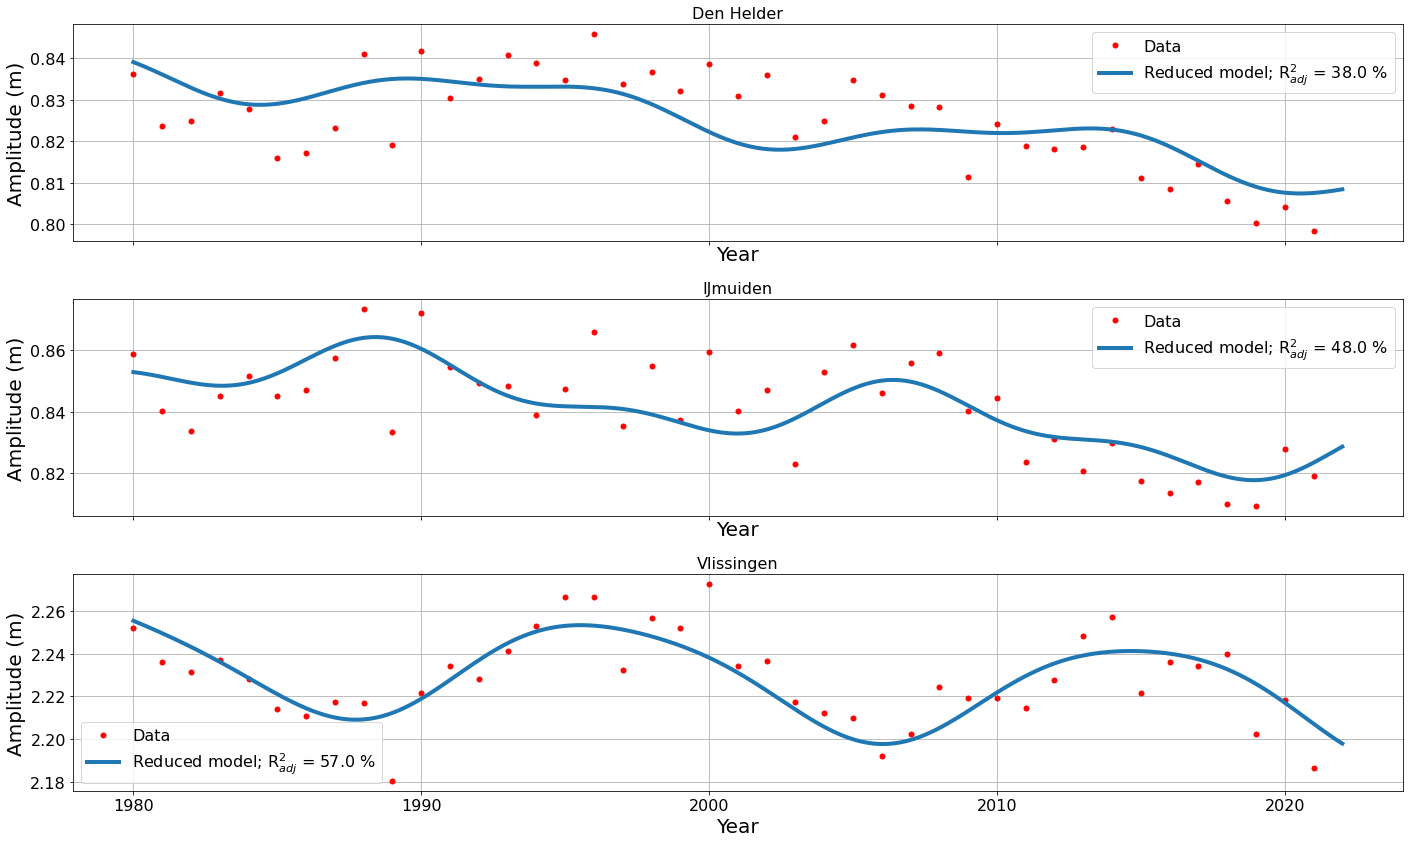

In [24]:
xgr = np.linspace(1980, 2022, 1000)

fig, ax = plt.subplots(nrows = len(names), ncols = 1, sharex = True, sharey = False, figsize = (20, len(names) * 4))

for i, nm in enumerate(names):
    data = df[df['naam'] == nm]

    plt.subplot(len(names),1,i+1)
    
    stplot.plot_data(
        data['year'], data[var], 'r.', label = 'Data',
        markersize = 10)

    stplot.plot_model(
        mdl.reducedModel, data['year'], data[var], xgr, modelname = 'Reduced model'
    )
    
    plt.title(nm)
    plt.xlabel('Year')
    plt.ylabel('Amplitude (m)')

    plt.legend()

plt.tight_layout()
plt.savefig(r'../pics/M2+S2_model3.jpg')
    

In [25]:
df.groupby('naam').apply(
    lambda x: pd.DataFrame(sup.Ftest_classic_direct(mdl.reducedModel, x['year'], x[var]), index = [0])
)

,,F,p,alpha,Falpha,Reject H0?
naam,,,,,,
Delfzijl,0,2.078401,0.080961,0.05,2.371781,False
Den Helder,0,5.135175,0.000710,0.05,2.371781,True
Harlingen,0,1.570829,0.184862,0.05,2.371781,False
Hoek van Holland,0,0.776755,0.593627,0.05,2.371781,False
IJmuiden,0,7.324657,0.000040,0.05,2.371781,True
Vlissingen,0,10.108899,0.000002,0.05,2.371781,True


In [26]:
df.groupby('naam').apply(
    lambda x: pd.DataFrame(sup.Ftest_reduced_direct(mdl.reducedModel, mdl.model1, x['year'], x[var]), index = [0])
)

,,F,p,alpha,Falpha,Reject H0?
naam,,,,,,
Delfzijl,0,2.711641,4.563557e-02,0.05,2.641465,True
Den Helder,0,1.789417,1.530287e-01,0.05,2.641465,False
Harlingen,0,2.228285,8.589941e-02,0.05,2.641465,False
Hoek van Holland,0,1.045529,3.978432e-01,0.05,2.641465,False
IJmuiden,0,3.377350,1.941514e-02,0.05,2.641465,True
Vlissingen,0,14.532556,4.350076e-07,0.05,2.641465,True


#### Fitting model

In [27]:
param = pd.DataFrame(columns = [
    'name',
    'var',
    'model',
    'intercept',
    'slope',
    'A_885',
    'A_1861',
    'Rsqadj'], dtype = float)

In [28]:
# Model 3
tmp = pd.DataFrame()

namestore = []
varstore = []
modelstore = []
intercept = []
slope = []
acceleration = []
jerk = []
A_885 = []
A_1861 = []
t0 = []
Rsqadj = []

for vr in [var]:
    for nm in names:
        """
        if nm == 'Delfzijl':
            if vr != 'z0':
                continue
        """
        data = df[df['naam'] == nm]
        res = gf.fit_with_uncert(
            mdl.reducedModel,
            data['year'],
            data[vr])

        p = res[0]

        namestore.append(nm)
        varstore.append(vr)
        modelstore.append('Reduced model')
        intercept.append(p[0])
        slope.append(p[1])
        A_885.append(np.sqrt(p[2]**2 + p[3]**2))
        A_1861.append(np.sqrt(p[4]**2 + p[5]**2))
        Rsqadj.append(res[5])
        

tmp['name'] = namestore
tmp['var'] = varstore
tmp['model'] = modelstore
tmp['intercept'] = intercept
tmp['slope'] = slope
tmp['A_885'] = A_885
tmp['A_1861'] = A_1861
tmp['Rsqadj'] = Rsqadj

param = pd.concat([param, tmp])

In [29]:
# Set units (length mm and time centuries) for publication table
param['intercept'] = (1000 * param['intercept']).round()
param['slope'] = (1e5 * param['slope']).round()
param['A_885'] = (1e3 * param['A_885']).round()
param['A_1861'] = (1e3 * param['A_1861']).round()
param['Rsqadj'] = (1e2 * param['Rsqadj']).round()
#param['p-value'] = (1e2 * param['p-value']).apply(lambda x: sf.round(x, 2))

In [30]:
param.sort_values(by = ['name', 'model'], inplace = True)

In [31]:
param

,name,var,model,intercept,slope,A_885,A_1861,Rsqadj
0,Den Helder,M2+S2,Reduced model,826.0,-61.0,2.0,5.0,38.0
1,IJmuiden,M2+S2,Reduced model,842.0,-75.0,4.0,9.0,48.0
2,Vlissingen,M2+S2,Reduced model,2228.0,-58.0,3.0,24.0,57.0


In [32]:
param[(param['model'] == 'Reduced model')].drop(['var', 'intercept', 'model'], axis = 1).to_excel(r'../results/fitted_models_amplitude.xlsx', index = False)

#### End script
Prepared by HVEC lab, 2022